<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -q /content/drive/MyDrive/Colab_Notebooks/dls/21/archive.zip -d train

In [3]:
# !unzip -q /content/drive/MyDrive/archive.zip -d train

unzip:  cannot find or open /content/drive/MyDrive/archive.zip, /content/drive/MyDrive/archive.zip.zip or /content/drive/MyDrive/archive.zip.ZIP.


In [5]:
def get_dataloader(image_size, batch_size, stats):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    # tt.Normalize(*stats)
    ])
  dataset = ImageFolder(root="/content/train", transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return dataloader

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [7]:
image_size = 128

#TODO: build dataloader and transfer it to device

batch_size = 32
trainDir = "/content/train"
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
dataLoader = get_dataloader(image_size, batch_size, stats)

In [8]:
dataLoader.dataset[0][0].shape

torch.Size([3, 128, 128])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


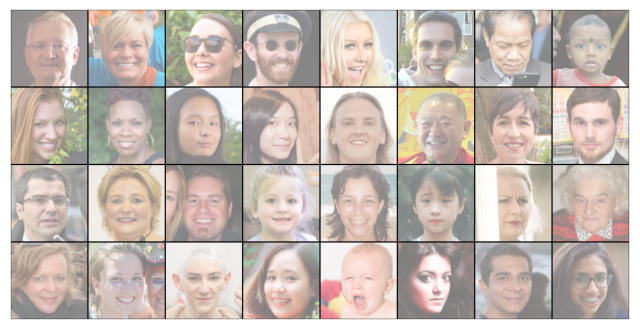

In [9]:
show_batch(dataLoader)

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(dataLoader, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    # out: 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 128 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.Tanh()
    nn.Sigmoid()
    # out: 3 x 128 x 128
)

torch.Size([32, 3, 128, 128])


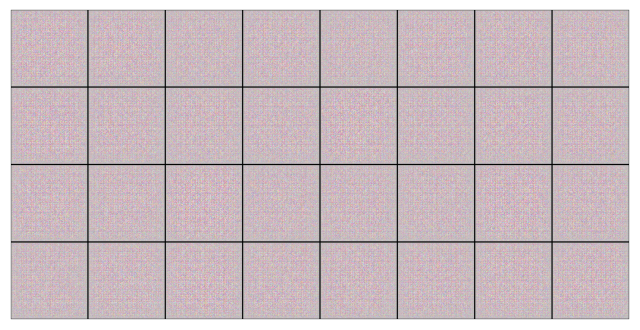

In [15]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [16]:
generator = to_device(generator, device)

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

def fit(model, criterion, epochs, lr, batch_size, start_idx=1):
  # TODO: build optimizers and train your GAN

    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            # print(f'real_preds = {real_preds.shape}')
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            # print(f'fake_images = {fake_images.shape}')

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

        # Save generated images
        # if epoch == epochs - 1:
        save_samples(epoch+start_idx, fixed_latent, show=False)


    return losses_g, losses_d, real_scores, fake_scores

In [20]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [21]:
epochs = 50

losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, epochs, lr, batch_size)

  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 13.2765, loss_d: 0.4083, real_score: 0.9197, fake_score: 0.1130
Saving generated-images-0001.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 12.5584, loss_d: 0.2500, real_score: 0.9409, fake_score: 0.0800
Saving generated-images-0002.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 5.1801, loss_d: 0.7213, real_score: 0.7784, fake_score: 0.1960
Saving generated-images-0003.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 4.0534, loss_d: 0.6141, real_score: 0.8022, fake_score: 0.2070
Saving generated-images-0004.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 3.9137, loss_d: 0.7490, real_score: 0.7660, fake_score: 0.2310
Saving generated-images-0005.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.3283, loss_d: 0.6897, real_score: 0.7831, fake_score: 0.2133
Saving generated-images-0006.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 4.3973, loss_d: 0.7313, real_score: 0.7696, fake_score: 0.2387
Saving generated-images-0007.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.4681, loss_d: 0.7873, real_score: 0.7482, fake_score: 0.2490
Saving generated-images-0008.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.3699, loss_d: 0.7791, real_score: 0.7465, fake_score: 0.2501
Saving generated-images-0009.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 4.1262, loss_d: 0.7424, real_score: 0.7554, fake_score: 0.2427
Saving generated-images-0010.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 4.0554, loss_d: 0.7609, real_score: 0.7471, fake_score: 0.2463
Saving generated-images-0011.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 4.0186, loss_d: 0.6986, real_score: 0.7590, fake_score: 0.2354
Saving generated-images-0012.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.1243, loss_d: 0.7613, real_score: 0.7531, fake_score: 0.2481
Saving generated-images-0013.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.0111, loss_d: 0.7393, real_score: 0.7479, fake_score: 0.2451
Saving generated-images-0014.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 4.1477, loss_d: 0.7145, real_score: 0.7624, fake_score: 0.2387
Saving generated-images-0015.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 4.3071, loss_d: 0.6651, real_score: 0.7746, fake_score: 0.2229
Saving generated-images-0016.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 4.3695, loss_d: 0.6464, real_score: 0.7797, fake_score: 0.2150
Saving generated-images-0017.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 4.2458, loss_d: 0.6053, real_score: 0.7891, fake_score: 0.2021
Saving generated-images-0018.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 4.4102, loss_d: 0.6188, real_score: 0.7920, fake_score: 0.2085
Saving generated-images-0019.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 4.5971, loss_d: 0.6196, real_score: 0.7972, fake_score: 0.2010
Saving generated-images-0020.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 4.5055, loss_d: 0.5975, real_score: 0.8003, fake_score: 0.1997
Saving generated-images-0021.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.3046, loss_d: 0.4856, real_score: 0.8237, fake_score: 0.1697
Saving generated-images-0022.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.4879, loss_d: 0.5456, real_score: 0.8145, fake_score: 0.1829
Saving generated-images-0023.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 4.7638, loss_d: 0.5073, real_score: 0.8250, fake_score: 0.1718
Saving generated-images-0024.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 4.6340, loss_d: 0.5176, real_score: 0.8240, fake_score: 0.1755
Saving generated-images-0025.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.9459, loss_d: 0.5248, real_score: 0.8257, fake_score: 0.1738
Saving generated-images-0026.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.8531, loss_d: 0.4662, real_score: 0.8407, fake_score: 0.1589
Saving generated-images-0027.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 4.7965, loss_d: 0.5106, real_score: 0.8356, fake_score: 0.1645
Saving generated-images-0028.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 4.7127, loss_d: 0.4886, real_score: 0.8351, fake_score: 0.1555
Saving generated-images-0029.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 4.6170, loss_d: 0.4508, real_score: 0.8498, fake_score: 0.1548
Saving generated-images-0030.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 4.9283, loss_d: 0.4565, real_score: 0.8450, fake_score: 0.1545
Saving generated-images-0031.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 4.6817, loss_d: 0.4439, real_score: 0.8509, fake_score: 0.1465
Saving generated-images-0032.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 4.9321, loss_d: 0.4145, real_score: 0.8577, fake_score: 0.1418
Saving generated-images-0033.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 4.7767, loss_d: 0.3997, real_score: 0.8573, fake_score: 0.1392
Saving generated-images-0034.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 4.9517, loss_d: 0.4461, real_score: 0.8523, fake_score: 0.1450
Saving generated-images-0035.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 4.9560, loss_d: 0.3536, real_score: 0.8755, fake_score: 0.1257
Saving generated-images-0036.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.0945, loss_d: 0.4332, real_score: 0.8535, fake_score: 0.1458
Saving generated-images-0037.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 5.1811, loss_d: 0.3794, real_score: 0.8688, fake_score: 0.1282
Saving generated-images-0038.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.0369, loss_d: 0.4061, real_score: 0.8650, fake_score: 0.1364
Saving generated-images-0039.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 5.1605, loss_d: 0.3929, real_score: 0.8642, fake_score: 0.1349
Saving generated-images-0040.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 4.9380, loss_d: 0.3284, real_score: 0.8784, fake_score: 0.1166
Saving generated-images-0041.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 5.2557, loss_d: 0.4008, real_score: 0.8675, fake_score: 0.1320
Saving generated-images-0042.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.9703, loss_d: 0.4211, real_score: 0.8643, fake_score: 0.1331
Saving generated-images-0043.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 4.8534, loss_d: 0.3204, real_score: 0.8892, fake_score: 0.1137
Saving generated-images-0044.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.9501, loss_d: 0.3327, real_score: 0.8855, fake_score: 0.1116
Saving generated-images-0045.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 5.1893, loss_d: 0.4657, real_score: 0.8578, fake_score: 0.1425
Saving generated-images-0046.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 4.7271, loss_d: 0.2501, real_score: 0.9042, fake_score: 0.0943
Saving generated-images-0047.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 5.0436, loss_d: 0.2198, real_score: 0.9133, fake_score: 0.0848
Saving generated-images-0048.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 5.2548, loss_d: 0.4241, real_score: 0.8672, fake_score: 0.1311
Saving generated-images-0049.png


  0%|          | 0/99 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 5.1523, loss_d: 0.4208, real_score: 0.8677, fake_score: 0.1312
Saving generated-images-0050.png


In [22]:
epoch_num = 50 # epochs
generated_img = cv2.imread(f'./generated/generated-images-00{epoch_num}.png')
generated_img = generated_img[:, :, [2, 1, 0]]

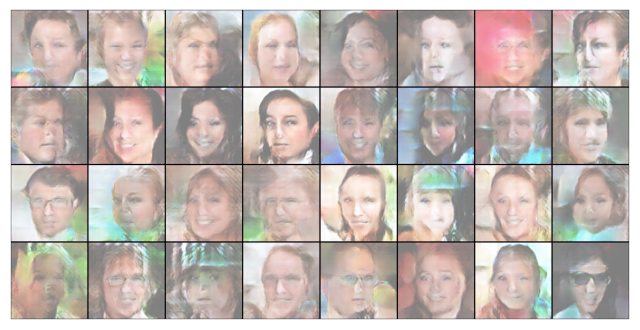

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

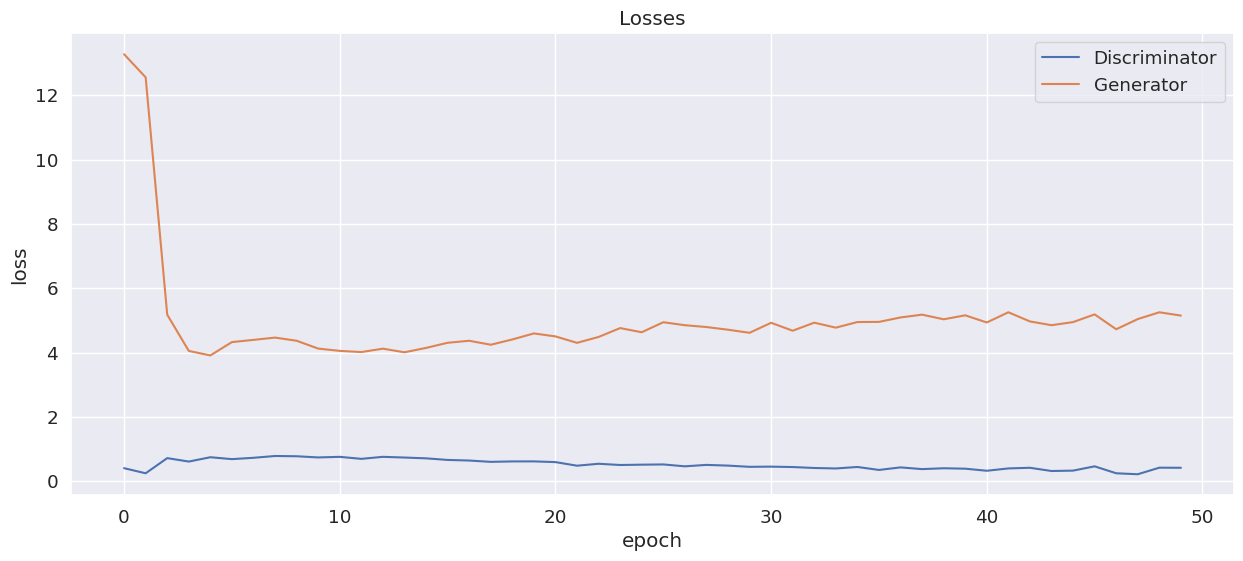

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

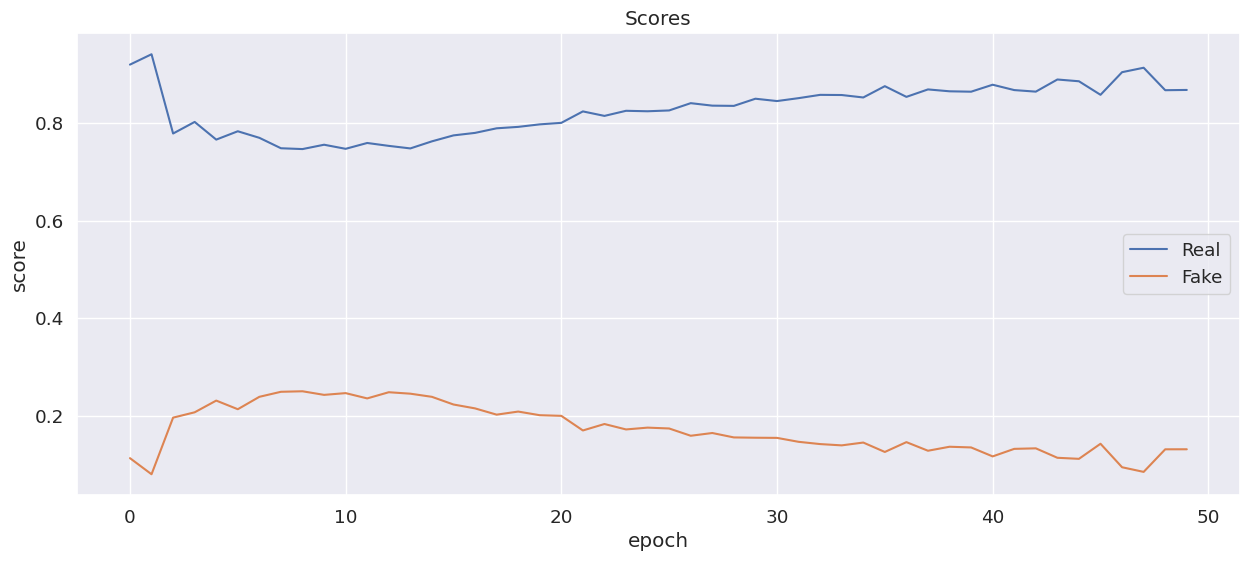

In [25]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

**лосс генератора сначала принимает большое значение - сеть не может сразу начать генерировать лица, затем уменьшается - у генератора получается "обмануть дискриминатор" (лос дискриминатора на этом этапе растет), потом лосс генератора и дискриминатора начинает немного стабилизироваться**

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

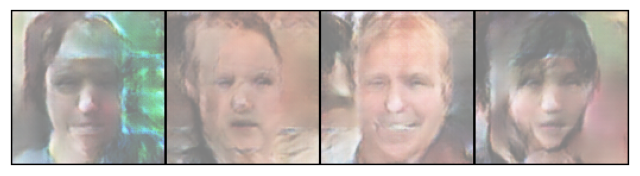

In [26]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
show_images(fake_images.cpu(), nmax=fixed_latent.shape[0])

Как вам качество получившихся изображений?

**лица видны**

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


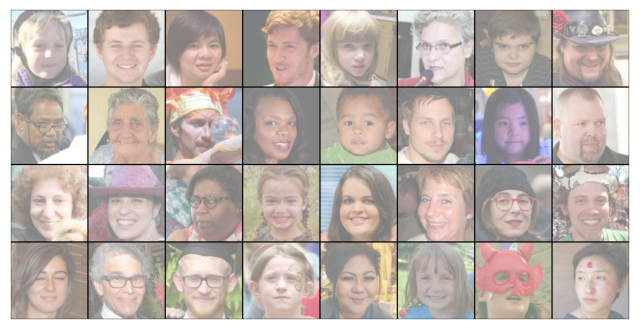

In [28]:
originalImages = []
for data, _ in dataLoader:
    originalImages.append(data.cpu())
originalImages = torch.cat((originalImages), 0)[:1000] # берем только 1000
originalTarget = torch.ones(len(originalImages), 1)
show_images(originalImages, 32)

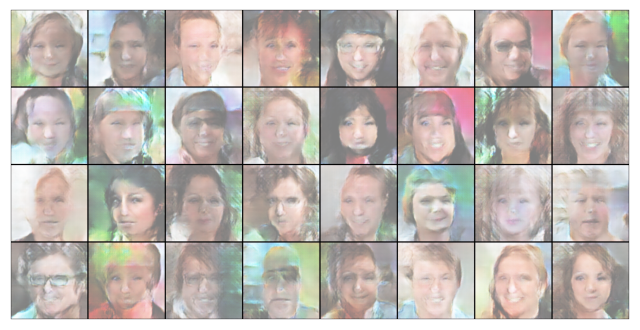

In [29]:
quantityImages = len(originalImages)
latent = torch.randn(quantityImages, latent_size, 1, 1, device=device)
fakeImages = model["generator"](latent)
fakeTarget = torch.zeros(len(originalImages), 1)
show_images(fakeImages.cpu(), 32)

In [30]:
X = np.concatenate((originalImages.detach().cpu().numpy(), fakeImages.detach().cpu().numpy()), 0)
Y = np.concatenate((originalTarget.detach().numpy(), fakeTarget.detach().numpy()), 0)
X.shape, Y.shape

((2000, 3, 128, 128), (2000, 1))

In [31]:
X = np.resize(X, (X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]))
Y = np.resize(Y, (Y.shape[0]))
X.shape, Y.shape

((2000, 49152), (2000,))

In [32]:
loo = LeaveOneOut()

accuracy = []
for train_index, test_index in loo.split(X):
  knn = KNeighborsClassifier(1)
  xTrain = X[train_index]
  yTrain = Y[train_index]
  knn.fit(xTrain, yTrain)
  accuracy.append(accuracy_score(Y[test_index], knn.predict(X[test_index])))

np.mean(accuracy)

0.7795

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?  
**в идеале надо 0,5 (дискриминатор не может отличить настоящую картинку от сгенерированной). Получился результат средний - 0.7795**

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [33]:
from sklearn.manifold import TSNE

<ipython-input-34-58484db81e73>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(downLatent[:,0], downLatent[:,1], c = Y, cmap=plt.cm.get_cmap("jet", 2))


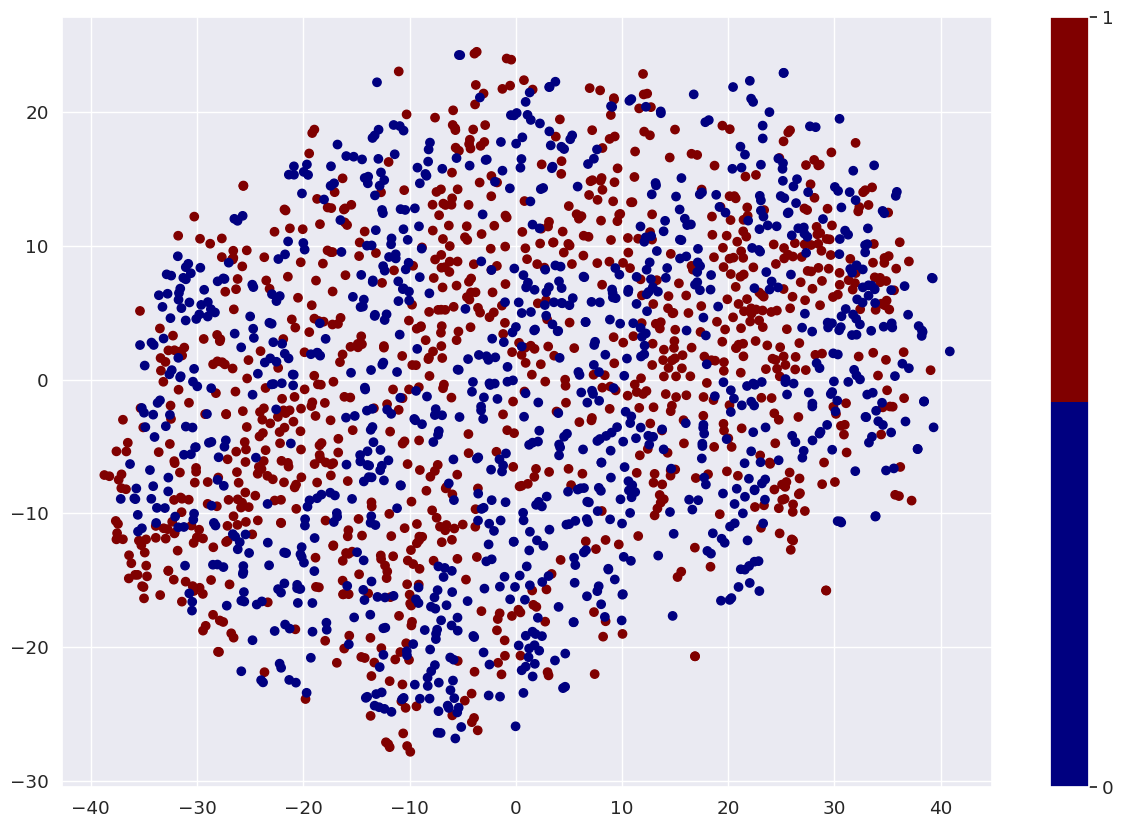

In [34]:
latent = []
label = []
downSpace = TSNE()
downLatent = downSpace.fit_transform(X)

plt.figure(figsize=(15, 10))
plt.scatter(downLatent[:,0], downLatent[:,1], c = Y, cmap=plt.cm.get_cmap("jet", 2))
plt.colorbar(ticks=range(2))
plt.show()

Прокомментируйте получившийся результат:  

**Распределения похожи, но есть небольшие скопления точек одного цвета - есть отличия между сгенерированными и истинными картинками.**